In [1]:
# Import Data Wrangling Libraries
import pandas as pd
import numpy as np 
import re

# Import Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import Machine Learning Libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

# Import NLP Libraries
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [2]:
#split up data with train and test 
train_df = pd.read_csv("data/training.csv")
test_df = pd.read_csv("data/test.csv")

train_df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [3]:
#find nulls
display(train_df.isnull().sum())
display(test_df.isnull().sum())


text     0
label    0
dtype: int64

text     0
label    0
dtype: int64

In [4]:
#find dups
display(train_df.duplicated())
display(test_df.duplicated())

0        False
1        False
2        False
3        False
4        False
         ...  
15995    False
15996    False
15997    False
15998    False
15999    False
Length: 16000, dtype: bool

0       False
1       False
2       False
3       False
4       False
        ...  
1995    False
1996    False
1997    False
1998    False
1999    False
Length: 2000, dtype: bool

<AxesSubplot: xlabel='label', ylabel='count'>

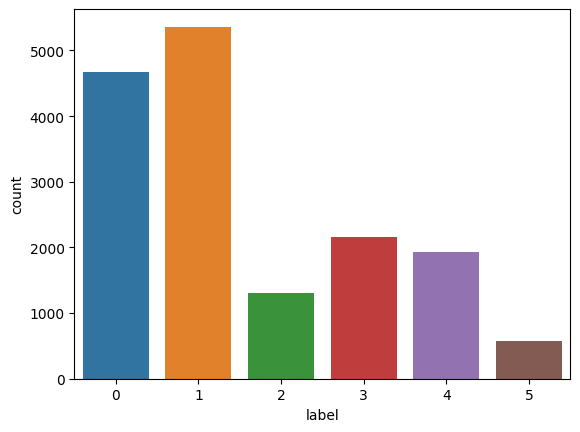

In [5]:
#label distribution for train split
sns.countplot(x=train_df['label'])

<AxesSubplot: xlabel='label', ylabel='count'>

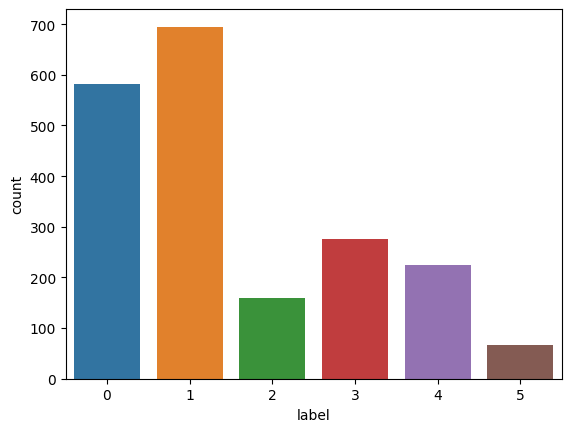

In [6]:
#label distribution for test split
sns.countplot(x=test_df['label'])

In [7]:
#helper function
def clean_tweets(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'[^\w\s]', '', tweet)
    words = word_tokenize(tweet)
    tweet = " ".join([word for word in words if word not in stopwords.words('english') ])
    words = word_tokenize(tweet)
    porter = PorterStemmer()
    tweet = " ".join([ porter.stem(word) for word in words])
    return tweet

#apply helper function
train_df['cleaned_text'] = train_df['text'].apply(clean_tweets)
test_df['cleaned_text'] = test_df['text'].apply(clean_tweets)


/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


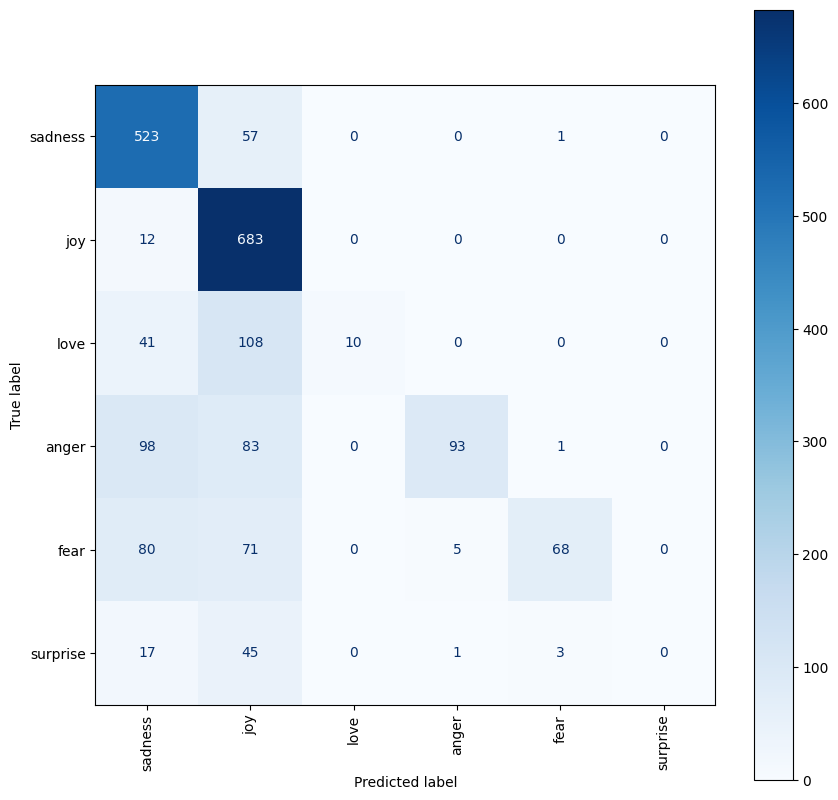

/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision_score,recall_score,f1_score
sadness,0.678340,0.900172,0.773669
joy,0.652340,0.982734,0.784156
love,1.000000,0.062893,0.118343
anger,0.939394,0.338182,0.497326
fear,0.931507,0.303571,0.457912
surprise,0.000000,0.000000,0.000000


In [8]:
# Tfid Model

#split features and label
X_train = train_df['cleaned_text']
y_train = train_df['label']

X_test = test_df['cleaned_text']
y_test = test_df['label']

#Fit and Transform
X_temp = pd.concat([X_train,X_test])
vectorizer = TfidfVectorizer()
vectorizer.fit(X_temp)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

#Create model and predict
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Create confusion matrix for Tfid model
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(model, X_test, y_test, display_labels=['sadness','joy','love','anger','fear','surprise'], cmap=plt.cm.Blues, ax=ax)
plt.xticks(rotation=90)
plt.show()

#display metrics
metrics_df = {
    'precision_score' : precision_score(y_test, y_pred, average=None),
    'recall_score' : recall_score(y_test, y_pred, average=None),
    'f1_score' : f1_score(y_test, y_pred, average=None)
}

display(pd.DataFrame(metrics_df, index=['sadness','joy','love','anger','fear','surprise']))

/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


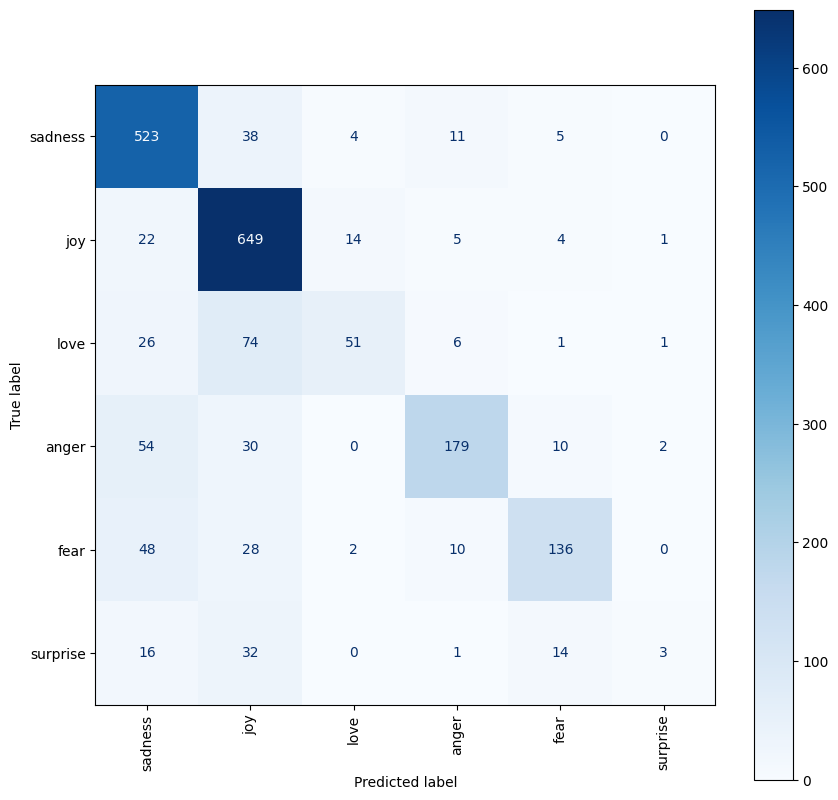

,precision_score,recall_score,f1_score
sadness,0.759071,0.900172,0.823622
joy,0.762632,0.933813,0.839586
love,0.718310,0.320755,0.443478
anger,0.844340,0.650909,0.735113
fear,0.800000,0.607143,0.690355
surprise,0.428571,0.045455,0.082192


In [9]:
#Bag of Words Model

#split features and label
X_train = train_df['cleaned_text']
y_train = train_df['label']

X_test = test_df['cleaned_text']
y_test = test_df['label']

#Fit and Transform
vectorizer = CountVectorizer()
vectorizer.fit(X_temp)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

#Create model and predict
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Create confusion matrix for BOW model
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(model, X_test, y_test, display_labels=['sadness','joy','love','anger','fear','surprise'], cmap=plt.cm.Blues, ax=ax)
plt.xticks(rotation=90)
plt.show()

#display metrics
metrics_df = {
    'precision_score' : precision_score(y_test, y_pred, average=None),
    'recall_score' : recall_score(y_test, y_pred, average=None),
    'f1_score' : f1_score(y_test, y_pred, average=None)
}

display(pd.DataFrame(metrics_df, index=['sadness','joy','love','anger','fear','surprise']))

/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


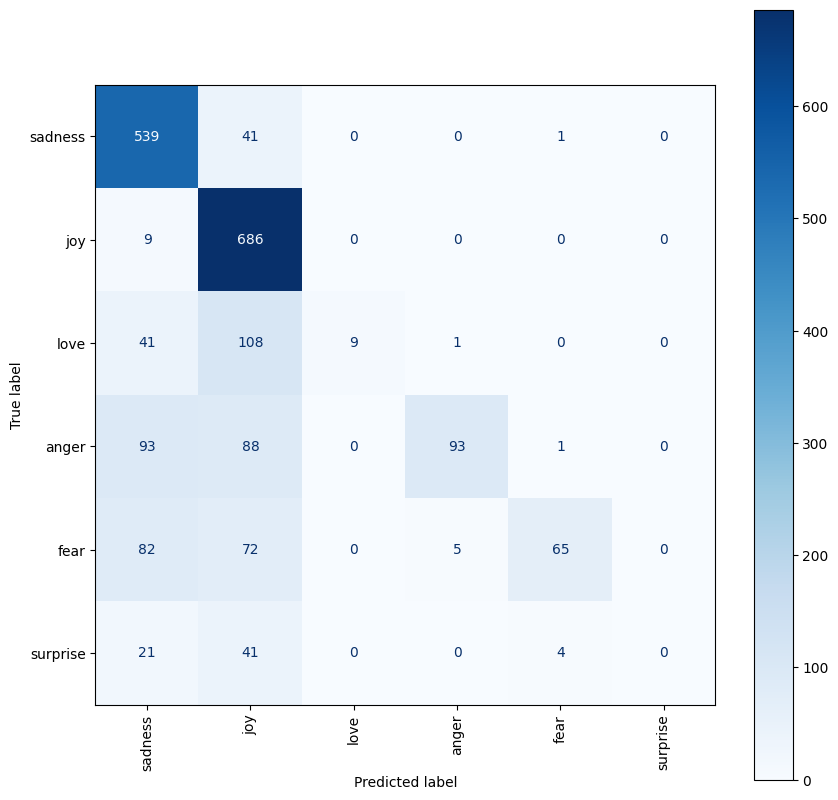

/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision_score,recall_score,f1_score
sadness,0.686624,0.927711,0.789165
joy,0.662162,0.987050,0.792605
love,1.000000,0.056604,0.107143
anger,0.939394,0.338182,0.497326
fear,0.915493,0.290179,0.440678
surprise,0.000000,0.000000,0.000000


In [15]:
#Bag of Words Model with Lemmatization #automobile => car truck => car #! DID NOT IMPROVE

def clean_tweets(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'[^\w\s]', '', tweet)
    words = word_tokenize(tweet)
    tweet = " ".join([word for word in words if word not in stopwords.words('english') ])
    words = word_tokenize(tweet)
    lem = WordNetLemmatizer()
    tweet = " ".join([ lem.lemmatize(word) for word in words])
    return tweet

train_df['cleaned_text_lem'] = train_df['text'].apply(clean_tweets)
test_df['cleaned_text_lem'] = test_df['text'].apply(clean_tweets)

#split features and label
X_train = train_df['cleaned_text_lem']
y_train = train_df['label']

X_test = test_df['cleaned_text_lem']
y_test = test_df['label']

#Fit and Transform
X_temp = pd.concat([X_train,X_test])
vectorizer = TfidfVectorizer()
vectorizer.fit(X_temp)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

#Create model and predict
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Create confusion matrix for Tfid model
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(model, X_test, y_test, display_labels=['sadness','joy','love','anger','fear','surprise'], cmap=plt.cm.Blues, ax=ax)
plt.xticks(rotation=90)
plt.show()

#display metrics
metrics_df = {
    'precision_score' : precision_score(y_test, y_pred, average=None),
    'recall_score' : recall_score(y_test, y_pred, average=None),
    'f1_score' : f1_score(y_test, y_pred, average=None)
}

display(pd.DataFrame(metrics_df, index=['sadness','joy','love','anger','fear','surprise']))

In [11]:
#Bag of Words Model with Special Character as Features #! Emojis Unicode with Regex, ! , text-based emoji

In [12]:
import pickle

# save best model 
# pickle.dump(model, open('BOW-MNB.pkl', 'wb'))

# save vectorizer
# pickle.dump(vectorizer, open('vectorizer-BOW-MNB.pkl', 'wb'))